In [1]:
# %% Import packages
from pprint import pprint
from itertools import chain, compress, product, count
from functools import reduce, partial, lru_cache
from glob import iglob
from typing import Generator

import xarray as xr
import pandas as pd
import cytoolz as tz
from cytoolz import compose, merge_with, groupby
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession, Row, DataFrame, functions as f
from dltools import load_combiner
from dltools.sacla import restructure, load_analyzer

In [2]:
# %% Load PySpark
builder = (
    SparkSession
    .builder
    .config("spark.executor.memory", "16g")
    .config("spark.driver.memory", "16g")
    .config("spark.driver.maxResultSize", "4g")
    .config(        
        "spark.jars.packages",
        "org.mongodb.spark:mongo-spark-connector_2.11:2.4.0,"
        "org.diana-hep:spark-root_2.11:0.1.15,"))

print("Loading PySpark...")
spark = builder.getOrCreate()
print("Done!")

Loading PySpark...
Done!


In [3]:
# %% Load data
from pyspark.sql.types import (
    ArrayType, BooleanType, LongType, StructField, StructType, DoubleType,
)
from dltools import SpkHits


print("Loading data...")
df = (
    spark
    .read
    .format("com.mongodb.spark.sql.DefaultSource")
    .option("uri", "mongodb://mongodb/sacla_2017b8065.resorted")
    .option("pipeline", """[
        {
            $match: {
                aq: {$in: [28, 29, 35, 36]},
                gm2: {$gt: 0.005}
            },
        },
        {
            $project: {
                tag: true,
                gm2: true,
                hits: {
                    $filter: {
                        input: "$hits",
                        as: "item",
                        cond: {$lte: ["$$item.flag", 14]},
                    },
                },
            },
        },
    ]""")
    .schema(
        StructType([
            StructField("tag", LongType()),
            StructField("gm2", DoubleType()),
            StructField("hits", SpkHits)
        ])
    )
    .load()
)
df.printSchema()

Loading data...
root
 |-- tag: long (nullable = true)
 |-- gm2: double (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- as_: map (nullable = false)
 |    |    |    |-- key: string
 |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |-- ke: double (nullable = false)
 |    |    |-- flag: integer (nullable = true)



In [4]:
combiner = load_combiner(3, [["C1p", "I2p", "I2p"]], allow_various=False)
combined = df.select("tag", "gm2", combiner("hits").alias("combined")).cache()
combined.printSchema()

root
 |-- tag: long (nullable = true)
 |-- gm2: double (nullable = true)
 |-- combined: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- comb: array (nullable = false)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- t: double (nullable = false)
 |    |    |    |    |-- x: double (nullable = false)
 |    |    |    |    |-- y: double (nullable = false)
 |    |    |    |    |-- as_: map (nullable = false)
 |    |    |    |    |    |-- key: string
 |    |    |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |    |    |-- ke: double (nullable = false)
 |    |    |    |    |-- flag: integer (nullable = true)
 |    |    |-- as_: map (nullable = false)
 |    |    |    |-- key: string
 |    |    |    

In [6]:
def gen():
    pubhit = count()
    for row in combined.toLocalIterator():
        d = row.asDict(True)
        yield {"dim": "tag", "tag": d["tag"], "gm2": d["gm2"]}
        for c in d["combined"]:
            i = next(pubhit)
            yield {"dim": "hit", "tag": d["tag"], "hit": i, "flag": c["flag"]}
            for j, (h, k) in enumerate(zip(c["comb"], ["C1p", "I2p", "I2p"])):
                yield {"dim": "hit,as_", "tag": d["tag"], "hit": i, "as_": f"h{j}{k}",
                       "t": h["t"], "x": h["x"], "y": h["y"],
                       "pz": h["as_"][k]["pz"], "px": h["as_"][k]["px"], "py": h["as_"][k]["py"],
                       "ke": h["as_"][k]["ke"]}


d = tz.groupby("dim", gen())
ds = xr.merge([
    pd.DataFrame(d["tag"]).set_index("tag").drop(columns="dim").to_xarray(),
    pd.DataFrame(d["hit"]).set_index("hit").drop(columns="dim").to_xarray().rename({"tag": "tag_"}),
    pd.DataFrame(d["hit,as_"]).set_index(["hit", "as_"]).drop(columns=["dim", "tag"]).to_xarray(),
])
da = ds[["t", "x", "y", "pz", "px", "py", "ke"]].to_array("quantity")
del d
ds

<xarray.Dataset>
Dimensions:  (as_: 3, hit: 131357, tag: 585878)
Coordinates:
  * tag      (tag) int64 158648231 158648232 158648233 ... 157417386 157417387
  * hit      (hit) int64 0 1 2 3 4 5 ... 131352 131353 131354 131355 131356
  * as_      (as_) object 'h0C1p' 'h1I2p' 'h2I2p'
Data variables:
    gm2      (tag) float64 0.009929 0.008909 0.009239 ... 0.01582 0.01761
    flag     (hit) int64 8 14 6 10 0 0 12 12 0 12 ... 14 14 14 14 14 0 0 0 13 6
    tag_     (hit) int64 158648234 158648363 158649099 ... 157417329 157417347
    ke       (hit, as_) float64 3.456 5.698 11.47 17.19 ... 14.19 5.365 9.141
    px       (hit, as_) float64 -68.93 -22.21 26.97 -89.6 ... 57.56 124.0 291.3
    py       (hit, as_) float64 -17.56 9.04 11.55 139.9 ... 132.0 -261.2 -183.5
    pz       (hit, as_) float64 -22.29 -310.3 440.6 -5.187 ... 45.63 87.26 192.1
    t        (hit, as_) float64 2.054e+03 3.878e+03 ... 3.932e+03 3.946e+03
    x        (hit, as_) float64 -12.25 -1.262 0.6659 ... 9.897 4.337 10.7

In [7]:
inlabframe = da.to_dataset(dim="as_")
inlabframe["summed"] = da.loc[{"quantity": ["pz", "px", "py", "ke"]}].sum("as_")
inlabframe

<xarray.Dataset>
Dimensions:   (hit: 131357, quantity: 7)
Coordinates:
  * quantity  (quantity) object 't' 'x' 'y' 'pz' 'px' 'py' 'ke'
  * hit       (hit) int64 0 1 2 3 4 5 ... 131352 131353 131354 131355 131356
Data variables:
    h0C1p     (quantity, hit) float64 2.054e+03 2.061e+03 ... 12.55 14.19
    h1I2p     (quantity, hit) float64 3.878e+03 3.906e+03 ... 3.467 5.365
    h2I2p     (quantity, hit) float64 3.977e+03 3.925e+03 ... 35.4 9.141
    summed    (quantity, hit) float64 nan nan nan nan ... 49.36 51.42 28.69

In [8]:
cond = {}

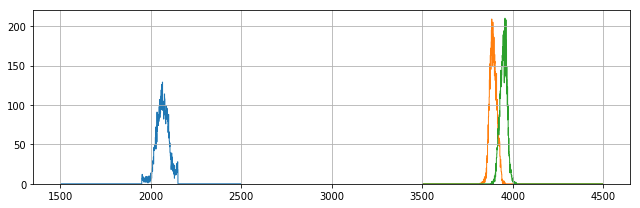

In [23]:
df = inlabframe.loc[{"quantity": "t"}].to_dataframe()
t0 = df["h0C1p"]
t1 = df["h1I2p"]
t2 = df["h2I2p"]

# where = slice(None)
where = cond["labframe"] & ~cond["bad_hit"]
# where = cond["molframe"]

plt.figure(figsize=(9, 3))
plt.hist(t0[where], bins=np.arange(1500, 2500, 1), histtype="step")
plt.hist(t1[where], bins=np.arange(3500, 4500, 1), histtype="step")
plt.hist(t2[where], bins=np.arange(3500, 4500, 1), histtype="step")
plt.grid(True)
plt.tight_layout()
plt.show()

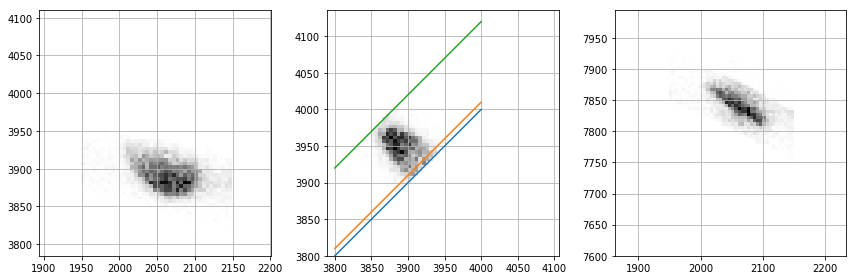

In [22]:
cond["bad_hit"] = 120 < (t2 - t1)

# where = slice(None)
where = cond["labframe"] & ~cond["bad_hit"]
norm = None
# norm = LogNorm()

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.hist2d(
    t0[where], t1[where],
    bins=(np.arange(1900, 2200, 5),
          np.arange(3800, 4100, 5)),
    cmap="Greys",
    norm=norm)
plt.axis("equal")
plt.grid(True)

plt.subplot(132)
plt.hist2d(
    t1[where], t2[where],
    bins=(np.arange(3800, 4100, 5),
          np.arange(3800, 4100, 5)),
    cmap="Greys",
    norm=norm)
x = np.linspace(3800, 4000)
plt.plot(x, x)
plt.plot(x, x + 10)
plt.plot(x, x + 120)
plt.axis("equal")
plt.grid(True)

plt.subplot(133)
plt.hist2d(
    t0[where], (t1 + t2)[where],
    bins=(np.arange(1900, 2200, 5),
          np.arange(7600, 8000, 5)),
    cmap="Greys",
    norm=norm)
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()

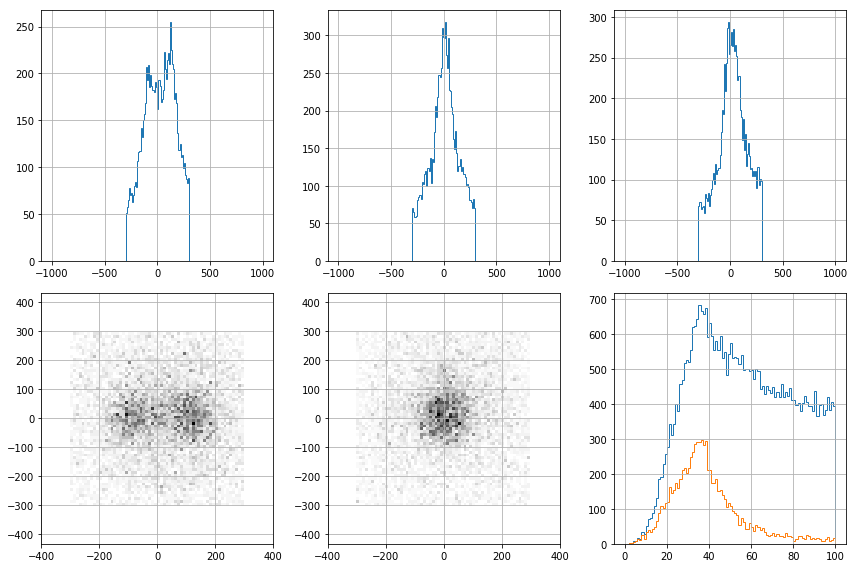

In [24]:
df = (
    inlabframe
    .loc[{"quantity": ["pz", "px", "py", "ke"]}]["summed"]
    .to_dataset(dim="quantity")
    .to_dataframe())
cond["labframe"] = (
    (-300 < df["px"]) & (df["px"] < 300)
    & (-300 < df["py"]) & (df["py"] < 300)
    & (-300 < df["pz"]) & (df["pz"] < 300)
)

# where = slice(None)
# where = cond["labframe"]
where = cond["labframe"] & ~cond["bad_hit"]
norm = None
# norm = LogNorm()

plt.figure(figsize=[12, 8])
plt.subplot(231)
plt.hist(
    df["px"][where],
    bins=np.linspace(-1000, 1000, 201),
    histtype="step")
plt.grid(True)
# plt.yscale("log")

plt.subplot(232)
plt.hist(
    df["py"][where],
    bins=np.linspace(-1000, 1000, 201),
    histtype="step")
plt.grid(True)
# plt.yscale("log")

plt.subplot(233)
plt.hist(
    df["pz"][where],
    bins=np.linspace(-1000, 1000, 201),
    histtype="step")
plt.grid(True)
# plt.yscale("log")

plt.subplot(234)
plt.hist2d(
    df["px"][where], df["py"][where],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys",
    norm=norm)
plt.axis("equal")
plt.grid(True)

plt.subplot(235)
plt.hist2d(
    df["py"][where], df["pz"][where],
    bins=2*[np.linspace(-400, 400, 81)],
    cmap="Greys",
    norm=norm)
plt.axis("equal")
plt.grid(True)

plt.subplot(236)
plt.hist(
    df["ke"],
    bins=np.linspace(0, 100, 101),
    histtype="step")
plt.hist(
    df["ke"][where],
    bins=np.linspace(0, 100, 101),
    histtype="step")
plt.grid(True)
# plt.yscale("log")
plt.tight_layout()
plt.show()